In [2]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [3]:
args = {
    'dataset': 'APAS',
}

In [4]:
folds_folder = "/datashare/"+args['dataset']+"/folds"
features_path = "/datashare/"+args['dataset']+"/kinematics_npy/"
videos_path = "/home/student/Project/npy_frames/"

gt_path_gestures = "/datashare/"+args['dataset']+"/transcriptions_gestures/"
gt_path_tools_left = "/datashare/"+args['dataset']+"/transcriptions_tools_left_new/"
gt_path_tools_right = "/datashare/"+args['dataset']+"/transcriptions_tools_right_new/"

mapping_gestures_file = "/datashare/"+args['dataset']+"/mapping_gestures.txt"
mapping_tool_file = "/datashare/"+args['dataset']+"/mapping_tools.txt"

In [5]:
def pars_ground_truth(gt_source):
        contant =[]
        for line in gt_source:
            info = line.split()
            line_contant = [info[2]] * (int(info[1])-int(info[0]) +1)
            contant = contant + line_contant
        return contant

In [6]:
gt_path_tools = {
    'left': gt_path_tools_left,
    'right': gt_path_tools_right
}

tools_files = {}
for hand in gt_path_tools:
    tools_files[hand] = [file_path for file_path in glob.glob(gt_path_tools[hand] + '*')]

tools_list = {}
for hand in tools_files:
    hand_tools_list = []
    for file_path in tools_files[hand]:
        with open(file_path, 'r') as file_ptr:
            lines = file_ptr.readlines()
            tools = pars_ground_truth(lines)
            hand_tools_list.append((tools, file_path))
    tools_list[hand] = hand_tools_list

### Check that all seq length are equal:

In [7]:
len(tools_list['left']) == len(tools_list['right'])

True

In [8]:
bad_vids = []
flag = True
count = 0
for i, (t_left, t_right) in enumerate(zip(tools_list['left'], tools_list['right'])):
    if not len(t_left[0]) == len(t_right[0]):
        print(f'index: {i}')
        print(f'{t_left[1]} - {len(t_left[0])}')
        print(f'{t_right[1]} - {len(t_right[0])}')
        print()
        bad_vids.append(i)
        count += 1
        flag = False
        # break
print(f'count: {count}')
print(f'flag: {flag}')

print()
for bad_index in bad_vids:
    bad_vid_left = tools_list['left'].pop(bad_index)
    bad_vid_right = tools_list['right'].pop(bad_index)
    print(f'{bad_vid_left[1]} removed.')
    print(f'{bad_vid_right[1]} removed.')

index: 93
/datashare/APAS/transcriptions_tools_left_new/P039_balloon2.txt - 3669
/datashare/APAS/transcriptions_tools_right_new/P039_balloon2.txt - 3801

count: 1
flag: False

/datashare/APAS/transcriptions_tools_left_new/P039_balloon2.txt removed.
/datashare/APAS/transcriptions_tools_right_new/P039_balloon2.txt removed.


In [9]:
max_seq = max(list(map(lambda x: len(x[0]), tools_list['left'])))
print(f'max_seq: {max_seq}')

max_seq: 14897


In [10]:
for i, (t_left, t_right) in enumerate(zip(tools_list['left'], tools_list['right'])):
    print(f'{t_left[1]} - {len(t_left[0])}')

/datashare/APAS/transcriptions_tools_left_new/P016_balloon1.txt - 4451
/datashare/APAS/transcriptions_tools_left_new/P016_balloon2.txt - 3911
/datashare/APAS/transcriptions_tools_left_new/P016_tissue1.txt - 6752
/datashare/APAS/transcriptions_tools_left_new/P016_tissue2.txt - 5671
/datashare/APAS/transcriptions_tools_left_new/P017_balloon1.txt - 3952
/datashare/APAS/transcriptions_tools_left_new/P017_balloon2.txt - 3336
/datashare/APAS/transcriptions_tools_left_new/P017_tissue1.txt - 4593
/datashare/APAS/transcriptions_tools_left_new/P017_tissue2.txt - 4530
/datashare/APAS/transcriptions_tools_left_new/P018_balloon1.txt - 3956
/datashare/APAS/transcriptions_tools_left_new/P018_balloon2.txt - 3680
/datashare/APAS/transcriptions_tools_left_new/P018_tissue1.txt - 5477
/datashare/APAS/transcriptions_tools_left_new/P018_tissue2.txt - 3892
/datashare/APAS/transcriptions_tools_left_new/P019_balloon1.txt - 4427
/datashare/APAS/transcriptions_tools_left_new/P019_balloon2.txt - 3722
/datashare/A

### Tools counts for video:

In [11]:
tools_stats = {}
for hand in tools_list:
    tools_stats_list = []
    for tools_tup in tools_list[hand]:
        unique, counts = np.unique(tools_tup[0], return_counts=True)
        tools_counts = dict(zip(unique, counts))
        tools_stats_list.append(tools_counts)
    tools_stats[hand] = tools_stats_list

In [12]:
# example:
tools_stats['left'][6]

{'T0': 2821, 'T1': 587, 'T2': 1185}

In [13]:
# sum over all videos:
full_tools_stats = {}
for hand in tools_stats:
    full_stats_dict = {
        'T0': 0,
        'T1': 0,
        'T2': 0,
        'T3': 0,
    }
    for stats in tools_stats[hand]:
        for tool in stats:
            full_stats_dict[tool] += stats[tool]

    full_tools_stats[hand] = full_stats_dict

In [14]:
full_tools_stats

{'left': {'T0': 426411, 'T1': 30930, 'T2': 159879, 'T3': 3203},
 'right': {'T0': 64430, 'T1': 495251, 'T2': 6649, 'T3': 54093}}

In [15]:
tools_percentage = {}
for hand in full_tools_stats:
    tools_hand_percentage = {}
    total_frames = 0
    for tool, appearances in full_tools_stats[hand].items():
        total_frames += appearances
    for tool, appearances in full_tools_stats[hand].items():
        tools_hand_percentage[tool] = appearances / total_frames
    tools_percentage[hand] = tools_hand_percentage

In [16]:
full_tools = {}
for hand in full_tools_stats:
    hand_full_tools = []
    for tool,counts in full_tools_stats[hand].items():
        hand_full_tools += [tool] * counts
    full_tools[hand] = hand_full_tools
print(len(full_tools['right']), len(full_tools['left']))
full_tools = pd.DataFrame(full_tools)

620423 620423


In [17]:
full_tools

,left,right
0,T0,T0
1,T0,T0
2,T0,T0
3,T0,T0
4,T0,T0
...,...,...
620418,T3,T3
620419,T3,T3
620420,T3,T3
620421,T3,T3


In [18]:
full_tools_hand_separated = []
for i in range(len(full_tools)):
    row = full_tools.iloc[i]
    left_tool = row['left']
    right_tool = row['right']
    full_tools_hand_separated.append([left_tool,'Left'])
    full_tools_hand_separated.append([right_tool,'Right'])

In [19]:
tools_percentage['right']


{'T0': 0.10384850335980451,
 'T1': 0.7982473248090416,
 'T2': 0.010716881869305297,
 'T3': 0.08718728996184862}

In [20]:
full_tools_hand_separated_df = pd.DataFrame(full_tools_hand_separated, columns=['Tool','Hand'])

In [21]:
full_tools_hand_separated_df

,Tool,Hand
0,T0,Left
1,T0,Right
2,T0,Left
3,T0,Right
4,T0,Left
...,...,...
1240841,T3,Right
1240842,T3,Left
1240843,T3,Right
1240844,T3,Left


left:
   - T0: 68.73%
   - T1: 4.99%
   - T2: 25.77%
   - T3: 0.52%
right:
   - T0: 10.38%
   - T1: 79.82%
   - T2: 1.07%
   - T3: 8.72%


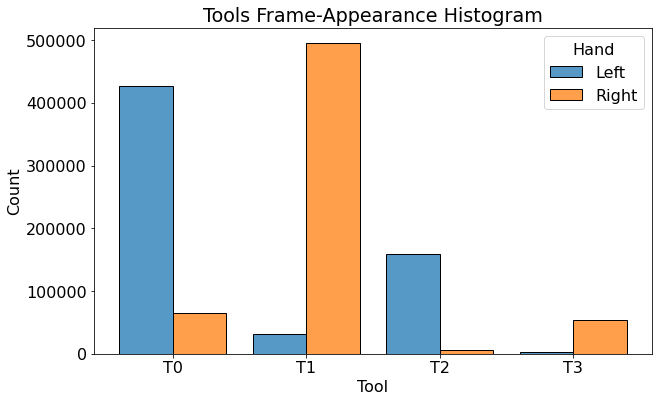

In [27]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,6))
plt.title('Tools Frame-Appearance Histogram')
sns.histplot(data=full_tools_hand_separated_df, x='Tool', hue='Hand', multiple='dodge', shrink=0.8, color=['b','g'])
for hand in tools_percentage:
    print(f'{hand}:')
    for tool, per in tools_percentage[hand].items():
        print(f'   - {tool}: {round(per*100,2)}%')
plt.savefig('Tools_Frame-Appearance_Histogram.png')